In [1]:
import os
from pathlib import Path
import uproot
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


# The following command display the current working directory (where jupyter has been launched)
# and select the output folder
cwd = os.getcwd()
folder = Path(cwd) / 'output'
if (not folder.is_dir()):
    print(f'ERROR: {folder} is not a folder.')
print(f'The Current Working Directory (CWD) is {cwd}')
print(f'The output folder is {folder}')

The Current Working Directory (CWD) is /Users/jemmabagg/Documents/Masters/picoPET-sim
The output folder is /Users/jemmabagg/Documents/Masters/picoPET-sim/output


The total simulation time: 0.00 minutes


<Figure size 1000x600 with 0 Axes>

/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/c

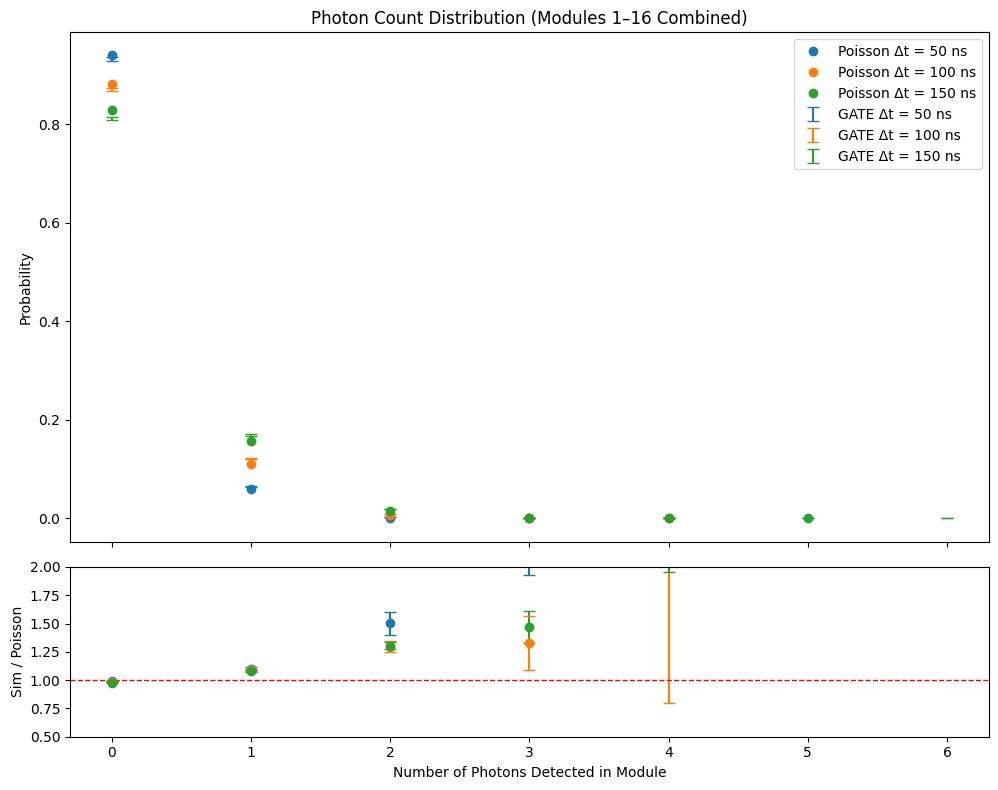

In [ ]:
from scipy.stats import poisson

#Load ROOT file
filename = os.path.join(folder, "output_vereos.root")
f = uproot.open(filename)
#print(f.keys())

singles_tree = f["Singles1"]
#print(singles_tree.keys())

#Extracting global time and volume that event took place in
global_times = singles_tree["GlobalTime"].array(library="np")
volumes = singles_tree["PreStepUniqueVolumeID"].array(library="np")

#Assuming the third number in each volume string corresponds to module number
module_ids = np.array([v.split('_')[2] for v in volumes])

#Getting total simulation time
T_min = global_times.min()
T_max = global_times.max()
print(f"The total simulation time: {(T_max - T_min) * 1e-9 / 60:.2f} minutes")

# Detector and physic constants
activity_per_source = 370e6  # Bq
module_area_mm2 = 961
module_area_cm2 = module_area_mm2 / 100
det_radius_cm = 15
lambda_m = (activity_per_source * module_area_cm2) / (4 * np.pi * det_radius_cm**2)

mods = 16
n = 5000  # samples per module
delta_t_ns = np.array([50,  100, 150])  # ns
#colors = plt.cm.cividis(np.linspace(0, 0.7, len(delta_t_ns)))
colors = plt.cm.tab10(np.arange(len(delta_t_ns)) % 10)

plt.figure(figsize=(10, 6))

# For storing results
all_counts = []
all_bin_centers = []
all_lambda_dt = []
sim_probs_list = []
poisson_probs_list = []
bin_centers_list = []
sim_errors_list = []

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

#Loop through Δt values
for t, color in zip(delta_t_ns, colors):

    delta_t = t * 1e-9  # convert to seconds
    lambda_dt = lambda_m * delta_t
    all_lambda_dt.append(lambda_dt)

    photon_counts = []

    #Sample each module independently
    for j in range(1, mods + 1):
        mod_mask = module_ids == str(j)
        mod_times = global_times[mod_mask]

        # Pre-sample t0 values for this module
        t0_samples = np.random.uniform(T_min, T_max - t, size=n)

        for t0 in t0_samples:
            count = np.count_nonzero((mod_times >= t0) & (mod_times < t0 + t))
            photon_counts.append(count)

    photon_counts = np.array(photon_counts)
    max_photon_count = photon_counts.max()

    #Histogram
    bins = np.arange(max_photon_count + 2) - 0.5
    counts, bin_edges = np.histogram(photon_counts, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    probabilities = counts / (n * mods)
    errors = np.sqrt(counts) / (n * mods) #absolute uncertainty

    # Store
    all_counts.append(counts)
    all_bin_centers.append(bin_centers)

    # Store for ratio panel
    # Poisson prediction
    poisson_probs = poisson.pmf(bin_centers, lambda_dt)

    sim_probs_list.append(probabilities)
    sim_errors_list.append(errors)
    poisson_probs_list.append(poisson_probs)
    bin_centers_list.append(bin_centers)

    #Plot histogram 
    # Plot in top panel
    ax1.errorbar(bin_centers, probabilities, yerr=errors, fmt='none', ecolor=color, capsize=4, label=f'GATE Δt = {t} ns')

    #Plot Poisson Prediction
    ax1.plot(bin_centers, poisson_probs, 'o', color=color, label=f'Poisson Δt = {t} ns')


# Format top panel
ax1.set_ylabel('Probability')
ax1.set_title(f'Photon Count Distribution (Modules 1–{mods} Combined)')
ax1.legend()


for bin_centers, sim_probs, sim_errors, poisson_probs, color, t in zip(
    bin_centers_list, sim_probs_list, sim_errors_list, poisson_probs_list, colors, delta_t_ns
):
    # Calculate the ratio: (Simulation value) / (Poisson prediction)
    ratio = sim_probs / poisson_probs

    # Calculate the uncertainty on the ratio (only using sim errors here)
    ratio_errors = sim_errors / poisson_probs

    # Handle any division issues (e.g. division by zero)
    ratio = np.nan_to_num(ratio)
    ratio_errors = np.nan_to_num(ratio_errors)

    # Plot the ratio with error bars
    ax2.errorbar(bin_centers, ratio, yerr=ratio_errors, fmt='o', color=color, capsize=4, label=f'Δt = {t} ns')

ax2.axhline(1.0, color='red', linestyle='--', linewidth=1)
ax2.set_ylabel('Sim / Poisson')
ax2.set_xlabel('Number of Photons Detected in Module')
ax2.set_ylim(0.5, 2)


plt.tight_layout()
plt.show()

In [ ]:
'''from scipy.stats import poisson

#Loading the ROOT file
filename = os.path.join(folder, "output_vereos.root")
f = uproot.open(filename)
#print(f.keys())

singles_tree = f["Singles1"]
#print(singles_tree.keys())

#Extracting the global time and volume that the event took place in
global_times = singles_tree["GlobalTime"].array(library="np")
volumes = singles_tree["PreStepUniqueVolumeID"].array(library="np")
#print(volumes)

#Assuming that the third number in each volume string corresponds to the module number 
module_ids = np.array([v.split('_')[2] for v in volumes])
#print(len(module_ids))

#Getting the total simulation time 
T_min = global_times.min()
T_max = global_times.max()
print(f"The total simulation time: {T_max-T_min} minutes")

# === Theoretical parameters ===
activity_per_source = 370e6  # Bq
#total_activity = 2 * activity_per_source  # 2 sources
module_area_mm2 = 961
module_area_cm2 = module_area_mm2 / 100  # convert to cm²
det_radius_cm = 15  # 150 mm = 15 cm
lambda_m = (activity_per_source * module_area_cm2) / (4 * np.pi * det_radius_cm**2)

mods = 16
n = 5000  # number of samples
delta_t_ns = np.array([20, 35, 50, 75, 100, 125, 150, 200, 250, 300])  # ns
colors = plt.cm.viridis(np.linspace(0, 1, len(delta_t_ns)))
max_photon_count = 0

plt.figure(figsize=(10,6))

all_counts = []
all_bin_centers = []
all_total_windows = []
all_lambda_dt = []

for t, color in zip(delta_t_ns, colors):

    delta_t = t * 1e-9  # convert to seconds
    
    lambda_dt = lambda_m * delta_t
    all_lambda_dt.append(lambda_dt)

    photon_counts = []

    for j in range(mods):
        j = j + 1

        for i in range(n):
    
            #Randomly choose a start time for the window
            t0 = np.random.uniform(T_min, T_max - t)
            #print(t0)

            #Filter the photons within the time window and in a target module
            mask = (global_times >= t0) & (global_times < t0 + t) & (module_ids == f"{j}")
            #print(mask)

            #Count photons in the target module during this time window
            count = np.sum(mask)
            photon_counts.append(count)

    photon_counts = np.array(photon_counts)
    max_photon_count = max(max_photon_count, photon_counts.max())

    # Histogram data
    bins = np.arange(photon_counts.max() + 2) - 0.5
    counts, bin_edges = np.histogram(photon_counts, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    probabilities = counts / (n * mods)  # P(n)
    errors = np.sqrt(counts) / (n * mods)  # absolute uncertainty

    #Store data for later 
    all_counts.append(counts)
    all_bin_centers.append(bin_centers)

    # Plot histogram with error bars
    plt.errorbar(bin_centers, probabilities, yerr=errors, fmt='none', ecolor=color, capsize=4, label=f'GATE Δt = {t}ns')

    #Poisson prediction 
    x = np.arange(0, photon_counts.max() + 1)
    plt.plot(x, poisson.pmf(x, lambda_dt), 'o', color=color, label=f'Prediction Δt = {t}ns')


plt.xlabel('Number of Photons Detected in Module')
plt.ylabel('Probability')
plt.title(f'Photon Count Distribution (Modules 1–{mods} Combined), for Δt = 250, 500, 750 ns')
plt.legend()
plt.tight_layout()
plt.show()'''

/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/c

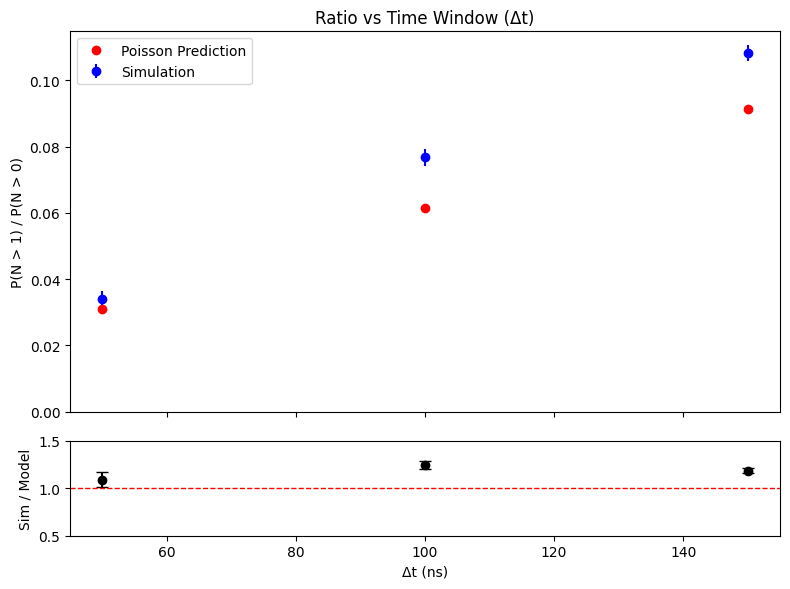

In [19]:
#Calculating ratios for simulation

sim_ratios = []
sim_ratio_errors = []

for counts, bin_centers, t in zip(all_counts, all_bin_centers, delta_t_ns):

    #Calculating Ratio P(N>1) / P(N>0) for Simulation
    total = np.sum(counts)
    b_0 = np.sum(counts[bin_centers > 0])
    p_b_0 =  b_0 / total
    b_1 = np.sum(counts[bin_centers > 1])
    p_b_1 = b_1 / total
    ratio = p_b_1 / p_b_0
    sim_ratios.append(ratio)

    #Calculating errors
    ratio_err = (1 / b_0) * np.sqrt( b_1 * (1 - (b_1 / b_0)))
    sim_ratio_errors.append(ratio_err)

    #print(f"Simulation: Δt = {t} ns | P(N>0): {p_b_0:.4f} | P(N>1): {p_b_1:.4f} | Ratio: {ratio:.4f} ± {ratio_err:.4f}")

#Calculating ratios for analytical model

analytic_ratios = []

for (lambda_dt, t) in zip(all_lambda_dt, delta_t_ns):

    #Calculating Ratio P(N>1) / P(N>0) for Analytical Model
    p_b_1 = 1 - np.exp(-lambda_dt) * (1 + lambda_dt)
    p_b_0 = 1 - np.exp(-lambda_dt)
    ratio = p_b_1 / p_b_0
    analytic_ratios.append(ratio)

    #print(f"Analytical: Δt = {t} ns | P(N>0): {p_b_0:.4f} | P(N>1): {p_b_1:.4f} | Ratio: {ratio:.4f}")


# Compute ratio between simulation and model
agreement_ratio = np.array(sim_ratios) / np.array(analytic_ratios)

# Optional: error propagation for the ratio
agreement_error = np.array(sim_ratio_errors) / np.array(analytic_ratios)

# Create two vertically stacked subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

# --- Top panel: Original plot ---
ax1.errorbar(delta_t_ns, sim_ratios, yerr=sim_ratio_errors, fmt='bo', ecolor='blue', label='Simulation')
ax1.plot(delta_t_ns, analytic_ratios, 'ro', label='Poisson Prediction')

ax1.set_ylabel('P(N > 1) / P(N > 0)')
ax1.set_title('Ratio vs Time Window (Δt)')
ax1.legend()
ax1.set_ylim(bottom=0)


# --- Bottom panel: Agreement ratio ---
ax2.errorbar(delta_t_ns, agreement_ratio, yerr=agreement_error, fmt='ko', capsize=4)
ax2.axhline(1.0, color='red', linestyle='--', linewidth=1)
ax2.set_xlabel('Δt (ns)')
ax2.set_ylabel('Sim / Model')
ax2.set_ylim(0.5, 1.5)  # adjust based on your data


plt.tight_layout()
plt.show()


In [ ]:
# Select times for a specific module, e.g., "1"
module_id_target = "1"
times_in_module = global_times[module_ids == module_id_target]

# Total number of photons in that module
N_photons = len(times_in_module)

# Total time duration of the simulation
T_total_ns = global_times.max() - global_times.min()

# Photon rate λ in photons per nanosecond
lambda_photon_rate = N_photons / T_total_ns

print(f"Photon rate for module {module_id_target}: {lambda_photon_rate:.4e} photons/ns")


Photon rate for module 1: 6.0292e-06 photons/ns
Photon rate for module 1: 6.03e+03 photons/s


In [5]:
filename = os.path.join(folder, "output_vereos.root")
f = uproot.open(filename)

# print the list of trees
for t in f:
    print(f'Tree {t}')

# get the first tree and print the branches
hits = f['Singles1']

df = f['Singles1'].arrays(["PostPosition_X", "PostPosition_Y", "PostPosition_Z", "TotalEnergyDeposit",  "GlobalTime", "LocalTime"], library="pd")

print(f'Number of hits : {hits.num_entries}')
for b in hits:
    print(f'Branch {b.name}')

df.head()

Tree Hits;1
Tree Singles1;1
Tree Singles2;1
Tree Singles3;1
Tree Singles4;1
Tree Singles5;1
Number of hits : 2424621.0
Branch PostPosition_X
Branch PostPosition_Y
Branch PostPosition_Z
Branch TotalEnergyDeposit
Branch PreStepUniqueVolumeID
Branch GlobalTime
Branch LocalTime


,PostPosition_X,PostPosition_Y,PostPosition_Z,TotalEnergyDeposit,GlobalTime,LocalTime
0,-101.116270,107.480231,4.5,0.163431,35.792911,1.095066
1,-63.374903,-133.402105,10.5,0.093680,43.707110,1.221129
2,-147.500000,10.500000,7.5,0.061692,76.630228,1.184752
3,-46.745071,140.290407,1.5,0.510999,82.100154,0.507945
4,57.831626,135.698206,4.5,0.223242,136.962576,0.738284


In [20]:
def find_coincidences(df: pd.DataFrame, time_window: float) -> pd.DataFrame:
    """
    Find photon coincidences within a given time window.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing photon measurements with the columns:
                           ["PostPosition_X", "PostPosition_Y", "PostPosition_Z",
                            "TotalEnergyDeposit", "GlobalTime", "LocalTime"].
        time_window (float): Maximum allowed time difference between photon pairs.
        
    Returns:
        pd.DataFrame: DataFrame where each row represents a coincidence pair.
                      The columns are the original attributes suffixed with _1 and _2.
    """
    # Sort the dataframe by GlobalTime for an efficient sliding-window search.
    df_sorted = df.sort_values("GlobalTime").reset_index(drop=True)
    times = df_sorted["GlobalTime"].values
    energies = df_sorted["TotalEnergyDeposit"]
    n = len(df_sorted)
    coincidences = []

    # Define energy window
    energy_lower = 0.511 - 0.030
    energy_upper = 0.511 + 0.030

    for i in range(n):
        j = np.searchsorted(times, times[i] + time_window, side='right')

        if energy_lower <= energies[i] <= energy_upper:
            for k in range(i + 1, j):
                if energy_lower <= energies[k] <= energy_upper:
                    pair = {}
                    for col in df_sorted.columns:
                        pair[f"{col}_1"] = df_sorted.iloc[i][col]
                        pair[f"{col}_2"] = df_sorted.iloc[k][col]

                    pair["TOF_Difference"] = df_sorted.iloc[k]["GlobalTime"] - df_sorted.iloc[i]["GlobalTime"]
                    coincidences.append(pair)


    
    return pd.DataFrame(coincidences)

In [21]:
time_window = 0.5  # example time window value
coincidences_df = find_coincidences(df, time_window)
print(coincidences_df.head())
print("Number of coincidences =  " + str(coincidences_df.shape[0]))

   PostPosition_X_1  PostPosition_X_2  PostPosition_Y_1  PostPosition_Y_2  \
0        147.500000       -147.500000          4.500000         -4.500000   
1         -7.500000          7.500000        147.500000       -147.500000   
2       -147.500000        147.500000          1.500000         -1.500000   
3         -1.500000         10.500000        147.500000       -147.500000   
4        111.722871       -111.722871         96.873629        -96.873629   

   PostPosition_Z_1  PostPosition_Z_2  TotalEnergyDeposit_1  \
0               7.5              -7.5              0.510999   
1              -1.5               4.5              0.510999   
2              10.5             -10.5              0.510999   
3              10.5              10.5              0.510999   
4              -1.5               1.5              0.510999   

   TotalEnergyDeposit_2  GlobalTime_1  GlobalTime_2  LocalTime_1  LocalTime_2  \
0              0.510999   2166.083340   2166.098399     0.489289     0.509050

/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/c

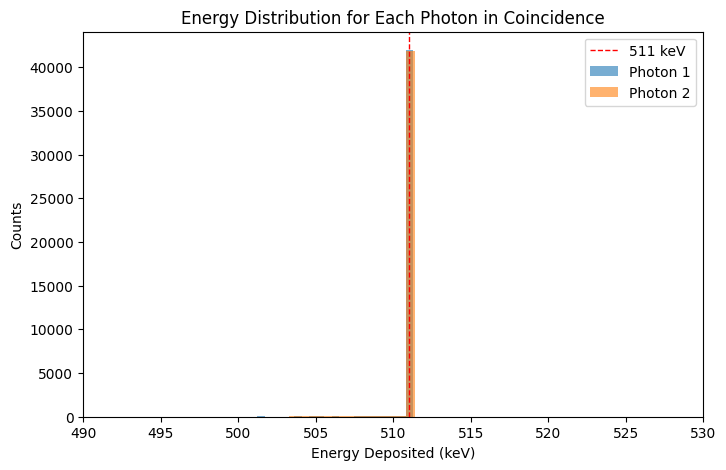

In [23]:
#Plotting a distribution of the total energy deposited for the two coincident photons

tot_energy1 = coincidences_df["TotalEnergyDeposit_1"] * 1e3 #eV to keV
tot_energy2 = coincidences_df["TotalEnergyDeposit_2"] * 1e3

plt.figure(figsize=(8, 5))
plt.hist(tot_energy1, bins=100, alpha=0.6, label="Photon 1")
plt.hist(tot_energy2, bins=100, alpha=0.6, label="Photon 2")
plt.xlabel("Energy Deposited (keV)")
plt.ylabel("Counts")
plt.axvline(511, color='r', linestyle='--', linewidth=1, label='511 keV')
plt.title("Energy Distribution for Each Photon in Coincidence")
plt.xlim(490, 530)
plt.legend()
plt.show()

In [44]:
from matplotlib.collections import LineCollection

def plot_physical_positions(coincidences_df: pd.DataFrame):
    """
    Plot physical positions of coincidence pairs in the x-y plane using vectorized drawing.
    
    For each coincidence pair, the two positions are plotted as small semi-transparent dots,
    and a semi-transparent red line is drawn connecting them. This version uses vectorized
    operations (via a LineCollection and bulk scatter) to dramatically speed up plotting
    for large numbers of pairs.
    
    Parameters:
        coincidences_df (pd.DataFrame): DataFrame with coincidence pairs,
            containing at least the columns:
                'PostPosition_X_1', 'PostPosition_Y_1',
                'PostPosition_X_2', 'PostPosition_Y_2'.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Extract the arrays of coordinates.
    x1 = coincidences_df["PostPosition_X_1"].values
    y1 = coincidences_df["PostPosition_Y_1"].values
    x2 = coincidences_df["PostPosition_X_2"].values
    y2 = coincidences_df["PostPosition_Y_2"].values

    # Build an array of segments for the red lines.
    # Each segment is defined as [[x1, y1], [x2, y2]]
    segments = np.stack([np.column_stack((x1, y1)), np.column_stack((x2, y2))], axis=1)

    # Create a LineCollection from all segments.
    line_collection = LineCollection(segments, colors='white', linewidths=0.5, alpha=0.05)
    ax.add_collection(line_collection)

    # Plot all blue dots at once.
    ax.scatter(x1, y1, color='blue', s=20, alpha=0.5, zorder=3)
    ax.scatter(x2, y2, color='blue', s=20, alpha=0.5, zorder=3)

    ax.set_xlabel("PostPosition_X")
    ax.set_ylabel("PostPosition_Y")
    ax.set_facecolor("black")
    ax.set_title("Coincidence Pairs: Physical Positions")

    plt.tight_layout()
    plt.show()

/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/c

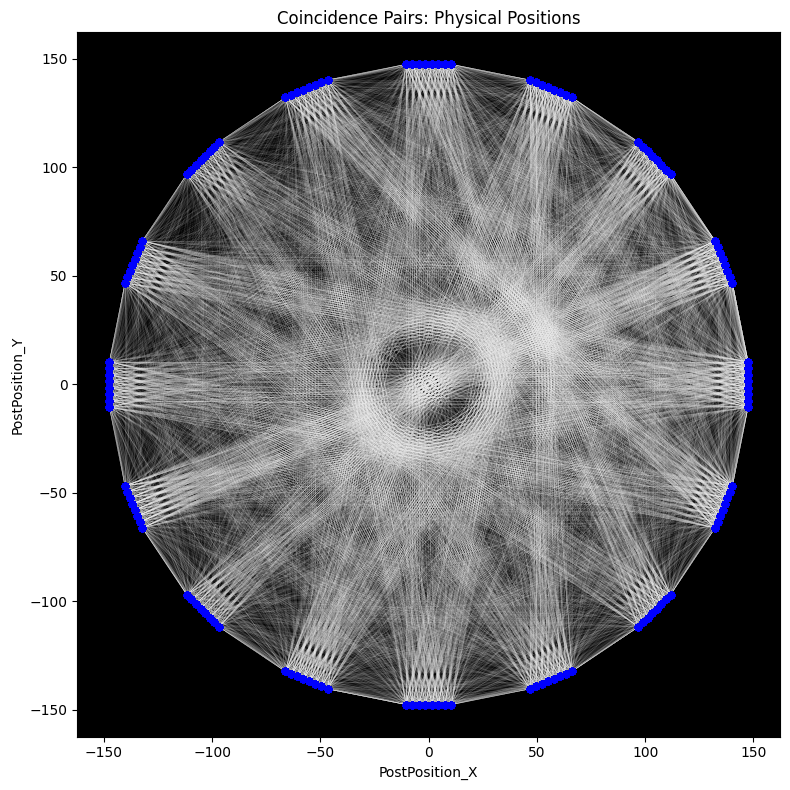

In [45]:
# Example usage:
# Assuming `coincidences_df` is your dataframe of coincidence pairs.
plot_physical_positions(coincidences_df)

In [46]:
def plot_sinogram(coincidences_df: pd.DataFrame,
                  bins_theta: int = 180, bins_r: int = 180,
                  bins_tof: int = 50, tof_resolution: int = 300e-12, use_tof: bool=False):
    """
    Plot the sinogram of coincidence pairs.
    
    For each coincidence pair, the sinogram parameters (theta, r) are calculated.
    Here, theta (in radians) is the angle of the normal to the line-of-response (LOR),
    and r is the perpendicular distance from the origin to the LOR.

    Adding the option to include a TOF-aware sinogram from coincidence pairs
    
    Parameters:
        coincidences_df (pd.DataFrame): DataFrame with coincidence pairs, containing
            'PostPosition_X_1', 'PostPosition_Y_1',
            'PostPosition_X_2', 'PostPosition_Y_2'.
        use_histogram (bool): If True, plot a 2D histogram (density image). 
                              If False, plot a scatter plot.
        bins_theta (int): Number of bins for theta (used only if use_histogram=True).
        bins_r (int): Number of bins for r (used only if use_histogram=True).
        bins_tof (int): Number of bins for TOF (if use_tof=True).
        tof_resolution (float): Detector timing resolution in seconds (e.g., 300 ps).
        use_tof (bool): Whether to include TOF binning.
    """
    #Plotting the TOF 3D Sinogram
    thetas = []
    rs = []
    tofs = []
    
    # Calculate sinogram parameters for each coincidence pair.
    for _, row in coincidences_df.iterrows():
        x1 = row["PostPosition_X_1"]
        y1 = row["PostPosition_Y_1"]
        x2 = row["PostPosition_X_2"]
        y2 = row["PostPosition_Y_2"]
        
        # Midpoint of the LOR
        xm = (x1 + x2) / 2.0
        ym = (y1 + y2) / 2.0
        
        # Orientation of the LOR.
        phi = np.arctan2(y2 - y1, x2 - x1)
        
        # Sinogram angle: the normal's angle (wrapped to [0, pi)).
        theta = (phi + np.pi/2) % np.pi
        # Perpendicular distance from the origin.
        r = xm * np.cos(theta) + ym * np.sin(theta)
        
        thetas.append(theta)
        rs.append(r)
        tofs.append(row["TOF_Difference"]) #Storing the TOF differences

    # Convert lists to NumPy arrays
    thetas = np.array(np.degrees(thetas))
    rs = np.array(rs)
    tofs = np.array(tofs)

    combined = np.column_stack((rs, thetas, tofs))
    #print(combined.shape)

    # Compute the 3D TOF-aware sinogram
    sinogram, edges = np.histogramdd(combined, bins=[bins_theta, bins_r, bins_tof])

    # edges is a single object containing all bin edges
    print("Sinogram Shape:", sinogram.shape)
    print("Number of Edge Sets:", len(edges))  # Should print 3
    
    '''
    # Choose a tof index (e.g., middle theta bin)
    tof_index = sinogram.shape[2] // 2

    # Extract sinogram slice for the selected theta bin
    sinogram_slice = sinogram[:, :, tof_index]

    # Plot TOF sinogram slice
    plt.figure(figsize=(8, 6))
    plt.imshow(sinogram_slice.T, aspect='auto', origin='lower',
            extent=[edges[1].min(), edges[1].max(), edges[2].min(), edges[2].max()], cmap='gray')

    plt.xlabel("Radial Distance r (mm)")
    plt.ylabel("Theta (radians)")
    plt.title(r"TOF Sinogram at $\Delta{t}$ = " f"{edges[2][tof_index]:.2f} s")
    plt.colorbar(label="Counts")
    plt.show()
    '''

    #Collapse TOF dimension by summing over TOF bins
    sinogram_2d = np.sum(sinogram, axis = 2)
    print("2D Sinogram Shape:", sinogram_2d.shape)

    if not use_tof:
        plt.figure(figsize=(8, 6))
        plt.imshow(sinogram_2d, cmap='gray_r', origin='lower', aspect='auto')
        plt.ylabel("Radial Distance r (mm)")
        plt.xlabel("Theta (radians)")
        plt.title(r"Sinogram (no TOF)")
        plt.colorbar(label="Counts")
        plt.show()
    else:
        #Define TOF resolution (FWHM -> standard deviation)
        tof_fwhm = tof_resolution * 3e8 / 2
        sigma_tof = tof_fwhm / 2.355 # FWHM - SD

        #Initialize weighted sinogram
        sinogram_weighted = np.zeros_like(sinogram_2d)

        #Apply the Gaussian weighting over TOF bins
        for i, tof_bin in enumerate(edges[2]):
            if i == 50: 
                break
            #r_bin = (3e8 * tof_bin) / 2
            #weight = np.exp(-((r_bin)**2) / (2 * sigma_tof **2))
            weight = np.exp(-((tof_bin)**2) / (2 * sigma_tof **2))
            sinogram_weighted += weight * sinogram[:, :, i] # Apply TOF weight

        plt.figure(figsize=(8, 6))
        plt.imshow(sinogram_weighted, cmap='gray_r', origin='lower', aspect='auto')
        plt.ylabel("Radial Distance r (mm)")
        plt.xlabel("Theta (radians)")
        plt.title(r"TOF Sinogram")
        plt.colorbar(label="Counts")
        plt.show()
        


Sinogram Shape: (180, 180, 50)
Number of Edge Sets: 3
2D Sinogram Shape: (180, 180)


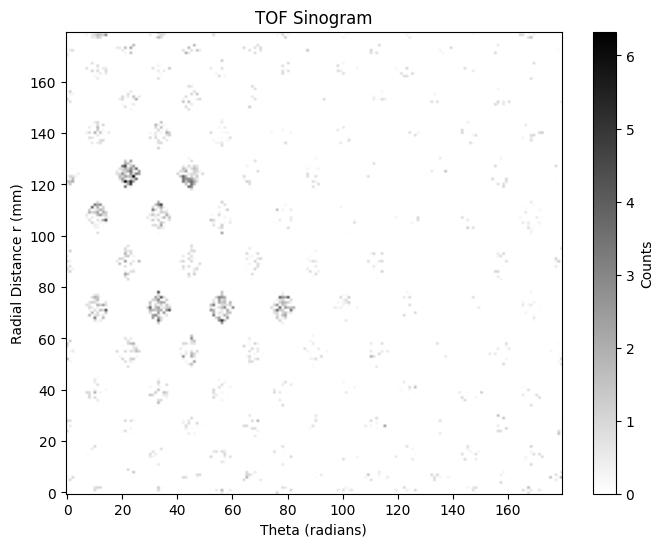

In [47]:
plot_sinogram(coincidences_df, use_tof=True)  # For scatter plot version
#plot_sinogram(coincidences_df, use_histogram=True)  # For 2D histogram version

In [48]:
from skimage.transform import iradon

def compute_sinogram(coincidences_df: pd.DataFrame, bins_theta: int = 180, bins_r: int = 180,
                     bins_tof: int = 50, tof_resolution: float = 300e-12, use_tof: bool = False):
    """
    Compute the sinogram from coincidence pairs.

    Each line-of-response (LOR) is parameterized by:
      - theta: the angle (in degrees) of the normal to the LOR (in [0,180))
      - r: the perpendicular distance from the origin to the LOR.

    Parameters:
      coincidences_df: DataFrame with coincidence pairs, containing columns:
         'PostPosition_X_1', 'PostPosition_Y_1',
         'PostPosition_X_2', 'PostPosition_Y_2'.
      bins_theta: Number of bins for theta (angles in degrees).
      bins_r: Number of bins for r (distance).
      bins_tof: Number of bins for TOF (if use_tof=True).
      tof_resolution: Detector timing resolution in seconds (e.g., 300 ps).
      use_tof: Whether to include TOF binning.

    Returns:
      sinogram: 2D numpy array (shape: [bins_r, bins_theta]).
      theta_centers: 1D array of theta bin centers (in degrees).
      r_edges: 1D array of r bin edges.
    """
    #Plotting the TOF 3D Sinogram
    thetas = []
    rs = []
    tofs = []
    
    # Calculate sinogram parameters for each coincidence pair.
    for _, row in coincidences_df.iterrows():
        x1 = row["PostPosition_X_1"]
        y1 = row["PostPosition_Y_1"]
        x2 = row["PostPosition_X_2"]
        y2 = row["PostPosition_Y_2"]
        
        # Midpoint of the LOR
        xm = (x1 + x2) / 2.0
        ym = (y1 + y2) / 2.0
        
        # Orientation of the LOR.
        phi = np.arctan2(y2 - y1, x2 - x1)
        
        # Sinogram angle: the normal's angle (wrapped to [0, pi)).
        theta = (phi + np.pi/2) % np.pi
        # Perpendicular distance from the origin.
        r = xm * np.cos(theta) + ym * np.sin(theta)
        
        thetas.append(theta)
        rs.append(r)
        tofs.append(row["TOF_Difference"]) #Storing the TOF differences

    # Convert lists to NumPy arrays
    thetas = np.array(np.degrees(thetas))
    rs = np.array(rs)
    tofs = np.array(tofs)

    combined = np.column_stack((rs, thetas, tofs))
    #print(combined.shape)

    # Compute the 3D TOF-aware sinogram
    sinogram, edges = np.histogramdd(combined, bins=[bins_theta, bins_r, bins_tof])
    
    '''
    # Choose a tof index (e.g., middle theta bin)
    tof_index = sinogram.shape[2] // 2

    # Extract sinogram slice for the selected theta bin
    sinogram_slice = sinogram[:, :, tof_index]

    # Plot TOF sinogram slice
    plt.figure(figsize=(8, 6))
    plt.imshow(sinogram_slice.T, aspect='auto', origin='lower',
            extent=[edges[1].min(), edges[1].max(), edges[2].min(), edges[2].max()], cmap='gray')

    plt.xlabel("Radial Distance r (mm)")
    plt.ylabel("Theta (radians)")
    plt.title(r"TOF Sinogram at $\Delta{t}$ = " f"{edges[2][tof_index]:.2f} s")
    plt.colorbar(label="Counts")
    plt.show()
    '''

    #Collapse TOF dimension by summing over TOF bins
    sinogram_2d = np.sum(sinogram, axis = 2)
    print("2D Sinogram Shape:", sinogram_2d.shape)

    theta_centres = (edges[1][:-1] + edges[1][1:]) / 2

    if not use_tof:
        return sinogram_2d, theta_centres
    else:
        #Define TOF resolution (FWHM -> standard deviation)
        tof_fwhm = tof_resolution * 3e8 / 2
        sigma_tof = tof_fwhm / 2.355 # FWHM - SD

        #Initialize weighted sinogram
        sinogram_weighted = np.zeros_like(sinogram_2d)

        #Apply the Gaussian weighting over TOF bins
        for i, tof_bin in enumerate(edges[2]):
            if i == 50: 
                break
            #r_bin = (3e8 * tof_bin) / 2
            weight = np.exp(-((tof_bin)**2) / (2 * sigma_tof **2))
            sinogram_weighted += weight * sinogram[:, :, i] # Apply TOF weight

        return sinogram_weighted, theta_centres

def reconstruct_pet_image(sinogram: np.ndarray, theta_centers: np.ndarray,
                          tof_bins: np.ndarray = None, use_tof: bool = False,
                          filter_name: str = 'ramp', output_size: int = None):
    """
    Reconstruct the PET image from a sinogram using filtered backprojection.

    If TOF is enabled, each TOF bin is backprojected separately and weighted by a 
    TOF-dependednt Gaussian function, if it is disabled it will fall back to a normal backprojection.

    Parameters:
      sinogram: 2D numpy array representing the sinogram (shape: [radial bins, angles]).
      theta_centers: 1D array of projection angles (in degrees) corresponding to the sinogram columns.
      filter_name: Filter to use in backprojection (default is 'ramp').
      output_size: Optional output image size (if None, it is inferred).

    Returns:
      reconstruction: 2D numpy array representing the reconstructed image.
    """

   
    return iradon(sinogram, theta=theta_centers, filter_name=filter_name,
                            circle=True, output_size=output_size)
    
   

def plot_reconstruction(reconstruction: np.ndarray, use_tof: bool):
    """
    Plot the reconstructed PET image with the origin at the centre,
    matching the coordinate system used for plotting physical coincidence positions.

    This version flips the reconstruction along the vertical axis so that
    the y-axis orientation matches that of the physical positions plot.
    """
    # Flip the image vertically to correct the y-axis orientation.
    reconstruction_flipped = np.flipud(reconstruction)

  
    
    nrows, ncols = reconstruction_flipped.shape
    # Set extent so that the image is centered at (0, 0)
    extent = [-ncols/2, ncols/2, -nrows/2, nrows/2]
    
    plt.figure(figsize=(8, 8))
    plt.imshow(reconstruction_flipped, cmap='gray', extent=extent, origin='lower')
    if use_tof:
      plt.title("Reconstructed PET Image (Filtered Backprojection, TOF)")
    else: 
      plt.title("Reconstructed PET Image (Filtered Backprojection)")
    plt.xlabel("X (units)")
    plt.ylabel("Y (units)")
    plt.colorbar(label='Intensity')
    plt.axis('equal')
    plt.show()


2D Sinogram Shape: (360, 180)


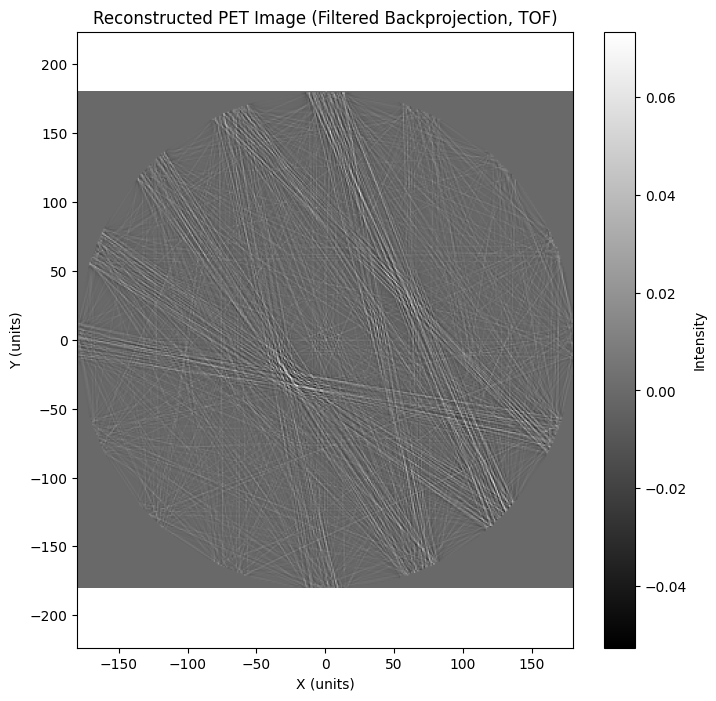

In [49]:
# === Example usage ===
# Assuming you have already computed a sinogram and the corresponding theta_centers,
# for example using your compute_sinogram function:

sinogram, theta_centers = compute_sinogram(coincidences_df, bins_theta=360, bins_r=180, use_tof=True)

# Reconstruct the PET image:
# You may specify output_size if you wish to control the dimensions.
reconstruction = reconstruct_pet_image(sinogram, theta_centers, filter_name='ramp')

# Plot the reconstructed image with the origin at the centre:
plot_reconstruction(reconstruction, use_tof=True)